In [1]:
import sys
import os
sys.path.append('../src')

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from structure_learning.approximators import PartitionMCMC
from structure_learning.data import Data
from structure_learning.distributions import Distribution, OPAD
from structure_learning.data_structures import DAG
from structure_learning.scores import BGeScore, BDeuScore
from structure_learning.evaluation.metrics import KLD, JSD, MAE, MSE, SHD

In [3]:
np.random.seed(32205)
data = np.zeros((200, 3))

data[:,0] = np.random.choice([1,2], size=200)
data[:,1] = np.random.choice([3,4], size=200)
data[:,2] = np.logical_and(data[:,0]==1, data[:,1]==3)
data = Data(pd.DataFrame(data, columns=['A', 'B', 'C']))
gt = DAG(np.array([[0,0,1],[0,0,1],[0,0,0]]), data.columns)

In [4]:
M = PartitionMCMC(max_iter=3000, data=data, score_object='bde', result_type='distribution')

In [5]:
mcmc_results, acceptance = M.run()
print('Acceptance_ratio:', acceptance)

MCMC iterations: 3001iter [00:00, 3529.42iter/s]                        

Acceptance_ratio: 0.41233333333333333


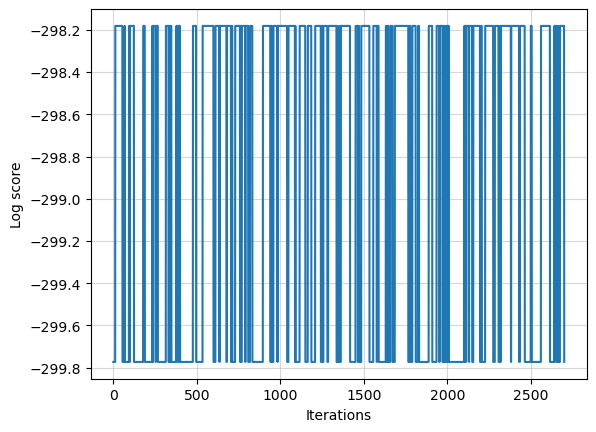

In [6]:
M.traceplot()

/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(particles[-limit:], rotation=90)


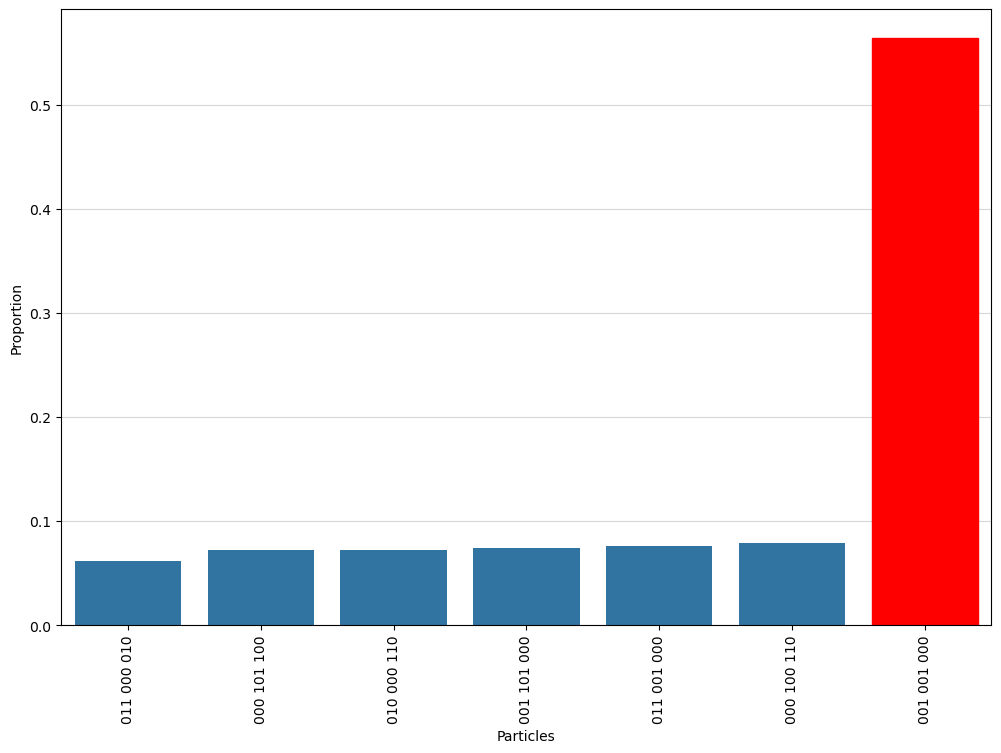

In [7]:
key = gt.to_key()
plt.rcParams['figure.figsize'] = 12,8
bars, keys, counts = mcmc_results.plot(sort=True, normalise=True, limit=100)
bars.containers[0][np.where(np.array(keys)==key)[0][0]].set_color('red')

In [8]:

opad_results = mcmc_results.to_opad()
opad_plus_results = mcmc_results.to_opad(plus=True)

Adding rejected particles


/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(particles[-limit:], rotation=90)


(<Axes: xlabel='Particles', ylabel='Proportion'>,
 array(['000 100 110', '010 000 110', '000 101 100', '001 101 000',
        '011 001 000', '011 000 010', '001 001 000'], dtype='<U11'),
 array([0.09165653, 0.09165653, 0.09165653, 0.09165653, 0.09165653,
        0.09165653, 0.4500608 ]))

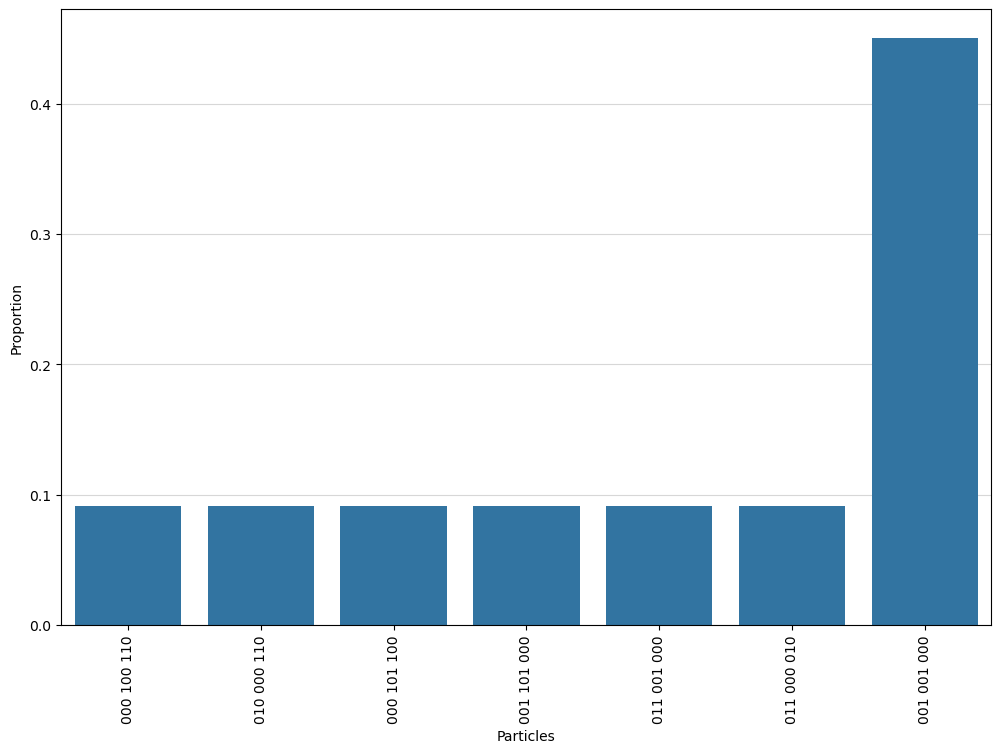

In [9]:
opad_results.plot()

/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(particles[-limit:], rotation=90)


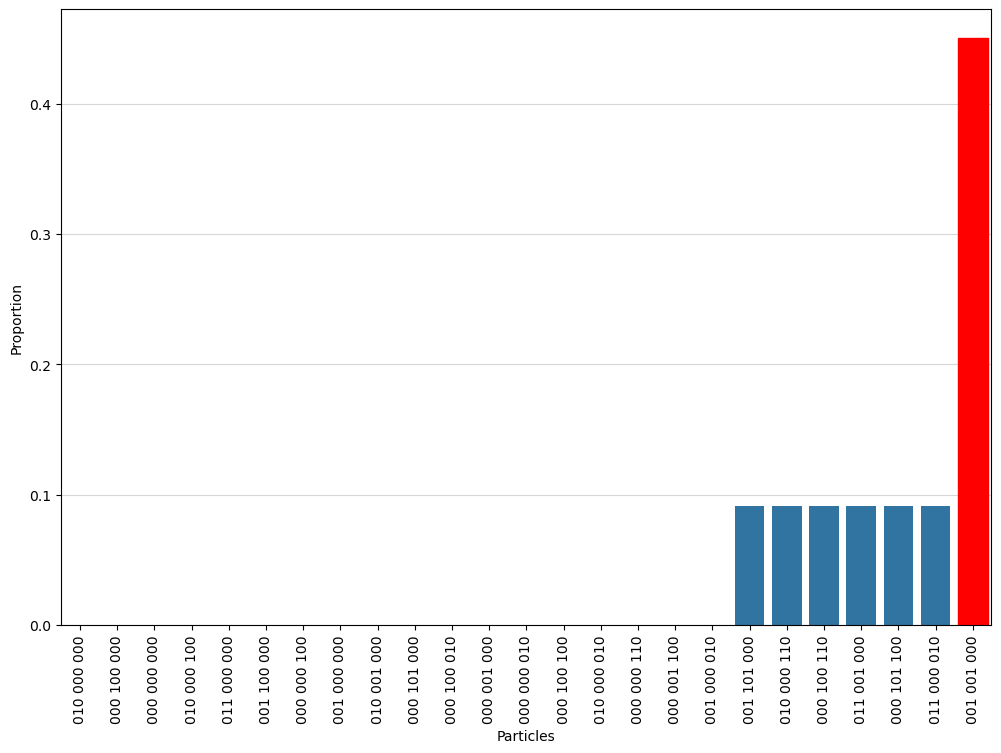

In [10]:
true_dist = Distribution.compute_distribution(data, score=BDeuScore)
bars2, keys, counts = true_dist.plot(prop='p', sort=True, limit=100)
bars2.containers[0][np.where(np.array(keys)==key)[0][0]].set_color('red')


### KLD

In [11]:
kld = KLD()
kld_mcmc = kld.compute(mcmc_results, true_dist)
kld_opad = kld.compute(opad_results, true_dist)
kld_opad_plus = kld.compute(opad_plus_results, true_dist)

print(kld_mcmc, kld_opad, kld_opad_plus)

0.027225747787648996 7.505501768889934e-12 5.003208971730239e-12


### JSD

In [12]:
jsd = JSD()
jsd_mcmc = jsd.compute(mcmc_results, true_dist)
jsd_opad = jsd.compute(opad_results, true_dist)
jsd_opad_plus = jsd.compute(opad_plus_results, true_dist)

print(jsd_mcmc, jsd_opad, jsd_opad_plus)

0.006839233237429096 2.4983396140332116e-17 -1.0175919715893359e-16


### MSE

In [13]:
mse = MSE()
mse_mcmc = mse.compute(mcmc_results, true_dist)
mse_opad = mse.compute(opad_results, true_dist)
mse_opad_plus = mse.compute(opad_plus_results, true_dist)

print(mse_mcmc, mse_opad, mse_opad_plus)

0.0006113716033811883 1.3210135461702819e-24 7.539803104434613e-25


### MAE

In [14]:
mae = MAE()
mae_mcmc = mae.compute(mcmc_results, true_dist)
mae_opad = mae.compute(opad_results, true_dist)
mae_opad_plus = mae.compute(opad_plus_results, true_dist)

print(mae_mcmc, mae_opad, mae_opad_plus)

0.009104355015934708 6.004346480577332e-13 4.0026777258419383e-13


### SHD


In [15]:
shd = SHD()
shd_mcmc = shd.compute(mcmc_results, gt)
shd_opad = shd.compute(opad_results, gt)
shd_opad_plus = shd.compute(opad_plus_results, gt)

print(shd_mcmc, shd_opad, shd_opad_plus)

0.12482149468450839 0.15712548645648408 0.08460603116904927
